In [115]:
# %load jupyter_default.py
import pandas as pd
import numpy as np
import os
import re
import datetime
import time
import glob
import json
from tqdm import tqdm_notebook
from colorama import Fore, Style

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
from slugify import slugify

%config InlineBackend.figure_format='retina'
sns.set() # Revert to matplotlib defaults
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.labelpad'] = 20
plt.rcParams['legend.fancybox'] = True
plt.style.use('ggplot')

SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 14, 16, 20
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=MEDIUM_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)

def savefig(name):
    plt.savefig(f'../../figures/{name}.png', bbox_inches='tight', dpi=300)

%reload_ext autoreload
%autoreload 2
    
%reload_ext version_information
%version_information pandas, numpy

Software versions
Python 3.6.8 64bit [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
IPython 6.4.0
OS Darwin 16.7.0 x86_64 i386 64bit
pandas 0.23.4
numpy 1.14.2
Wed May 08 14:00:36 2019 PDT

In [2]:
from google.cloud import bigquery

In [3]:
from dotenv import load_dotenv
load_dotenv('../../.env')

True

In [4]:
client = bigquery.Client()

# Page Paths
Alex's development notebook for page paths.

## Read data

### Read from bigquery (old code)

In [49]:
%%time
"""
Using bigquery
"""

def pull_daily_data(verbose=False):
    dataset = client.get_dataset('bigquery-public-data.google_analytics_sample')

    data = []
    for table in tqdm_notebook(list(client.list_tables(dataset))):
        if verbose:
            print('Querying {}'.format(table.table_id))
        query_job = client.query('''
            select
              date,
              sum(totals.visits),
              sum(totals.pageviews),
              sum(totals.transactions),
              sum(totals.transactionRevenue)
            from `bigquery-public-data.google_analytics_sample.{}`
            group by date;
        '''.format(table.table_id))
        results = query_job.result().to_dataframe()
        results.columns = ['date', 'visits', 'pageviews', 'transactions', 'transactionRevenue']
        data.append(results)

    df = pd.concat(data, ignore_index=True, sort=False)
    return df

bq_results = pull_daily_data()


CPU times: user 7.94 s, sys: 856 ms, total: 8.8 s
Wall time: 11min 29s


In [53]:
bq_results.head()

,date,visits,pageviews,transactions,transactionRevenue
0,20160801,1711,9843,34,6116060000
1,20160802,2140,11784,18,1361190000
2,20160803,2890,13724,None,None
3,20160804,3161,13326,17,1182890000
4,20160805,2702,13585,42,5594260000


### Read `jsonl` from google drive (old code)

In [7]:
%%time
"""
Using gdrive jsonl
"""
ERRORS = []

def pull_daily_data(verbose=False, raise_errors=False):
    dataset = sorted(glob.glob('/Volumes/GoogleDrive/My Drive/bigquery_ga_sample/*.jsonl'))

    data = []
    for table in tqdm_notebook(dataset):
        if verbose:
            print('Scanning {}'.format(table))
        with open(table, 'r') as f:
            table_data = []
            for line in f:
                d = json.loads(line)
                date = d['date']
                d = d['totals']
                try:
                    table_data.append([
                        date,
                        d['visits'],
                        d['pageviews'],
                        d['transactions'],
                        d['transactionRevenue'],
                    ])
                except Exception as e:
                    if verbose:
                        print('Error raised when reading row:\n{}'.format(e))
                    ERRORS.append([table, e])
                    if raise_errors:
                        raise(e)

            cols = ['date', 'visits', 'pageviews', 'transactions', 'transactionRevenue']
            results = (
                pd.DataFrame(table_data, columns=cols)
                    .groupby('date')[['visits', 'pageviews', 'transactions', 'transactionRevenue']]
                    .sum().reset_index()
            )
            data.append(results)

    df = pd.concat(data, ignore_index=True, sort=False)
    return df

jsonl_gdrive_results = pull_daily_data()


CPU times: user 7min 55s, sys: 1min 56s, total: 9min 52s
Wall time: 23min 14s


In [8]:
jsonl_gdrive_results

,date,visits,pageviews,transactions,transactionRevenue
0,20160801,1711,9843.0,34.0,6.116060e+09
1,20160802,2140,11784.0,18.0,1.361190e+09
2,20160803,2890,13724.0,NaN,NaN
3,20160804,3161,13326.0,17.0,1.182890e+09
4,20160805,2702,13585.0,42.0,5.594260e+09
5,20160806,1663,6926.0,10.0,1.891040e+09
6,20160807,1622,7239.0,16.0,2.410730e+09
7,20160808,2815,13179.0,36.0,5.273810e+09
8,20160809,2851,13411.0,44.0,5.596400e+09
9,20160810,2757,13003.0,46.0,4.284210e+09


### Read `jsonl` from local

In [10]:
%%time
"""
Using local jsonl
"""
ERRORS = []

def pull_daily_data(verbose=False, raise_errors=False):
    dataset = sorted(glob.glob('../../data/raw/*.jsonl'))

    data = []
    i = 0
    for table in tqdm_notebook(dataset):
        if verbose:
            print('Scanning {}'.format(table))
        with open(table, 'r') as f:
            table_data = []
            visitor_id_dates = {}
            for line in f:
                i += 1
                try:
                    d = json.loads(line)
                    d_visit = [
                        i,
                        d['date'],
                        d['device']['isMobile'],
                        d['totals']['transactions'],
                        len(d['hits']),
                    ]
                    for h in d['hits']:
                        table_data.append(d_visit + [
                            h['hitNumber'],
                            h['page']['pagePath'],
                            h['page']['pageTitle'],
                        ])

                except Exception as e:
                    if verbose:
                        print('Error raised when reading row:\n{}'.format(e))
                    ERRORS.append([table, e])
                    if raise_errors:
                        raise(e)

            cols = ['id', 'date', 'isMobile', 'transactions', 'numHits',
                    'hitNumber', 'pagePath', 'pageTitle',]
            results = pd.DataFrame(table_data, columns=cols)
            data.append(results)

    df = pd.concat(data, ignore_index=True, sort=False)
    return df

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 10 µs


In [11]:
jsonl_results = pull_daily_data(raise_errors=True, verbose=True)

Scanning ../../data/raw/ga_sessions_20160801.jsonl
Scanning ../../data/raw/ga_sessions_20160802.jsonl
Scanning ../../data/raw/ga_sessions_20160803.jsonl
Scanning ../../data/raw/ga_sessions_20160804.jsonl



KeyboardInterrupt: 

In [12]:
jsonl_results = pull_daily_data()

In [18]:
df = jsonl_results.copy()
df.date = pd.to_datetime(df.date)
df.to_csv('../../data/interim/page_paths_raw.csv', index=False)

In [19]:
def load_file(f_path):
    if not os.path.exists(f_path):
        print('No data found. Run data load script above.')
        return
    print('Loading {}'.format(f_path))
    df = pd.read_csv(f_path)
    df.date = pd.to_datetime(df.date)
    return df

# Looking forward to walrus operator for stuff like this...
tmp = load_file('../../data/interim/page_paths_raw.csv')
if tmp is not None:
    print('Loading from file')
    df = tmp.copy()
    del tmp

Loading ../../data/interim/page_paths_raw.csv
Loading from file


In [20]:
df.head()

,id,date,isMobile,transactions,numHits,hitNumber,pagePath,pageTitle
0,1,2016-08-01,False,NaN,3,1,/home,Home
1,1,2016-08-01,False,NaN,3,2,/google+redesign/gift+cards,Gift Cards
2,1,2016-08-01,False,NaN,3,3,/signin.html,The Google Merchandise Store - Log In
3,2,2016-08-01,False,NaN,3,1,/home,Home
4,2,2016-08-01,False,NaN,3,2,/google+redesign/apparel/men++s/men++s+t+shirts,Men's-T-Shirts


In [16]:
# df['week'] = df.date.apply(lambda x: x.strftime('%W'))
# df['year'] = df.date.apply(lambda x: x.strftime('%Y'))
# df['week_start'] = df[['week', 'year']].apply(
#     lambda x: datetime.datetime.strptime('{}-{}-1'.format(x.year, x.week), '%Y-%W-%w'),
#     axis=1
# )

In [17]:
df.dtypes

id                       int64
date            datetime64[ns]
isMobile                  bool
transactions           float64
numHits                  int64
hitNumber                int64
pagePath                object
pageTitle               object
dtype: object

## Exploring the dataset

In [23]:
df.date.isnull().sum()

0

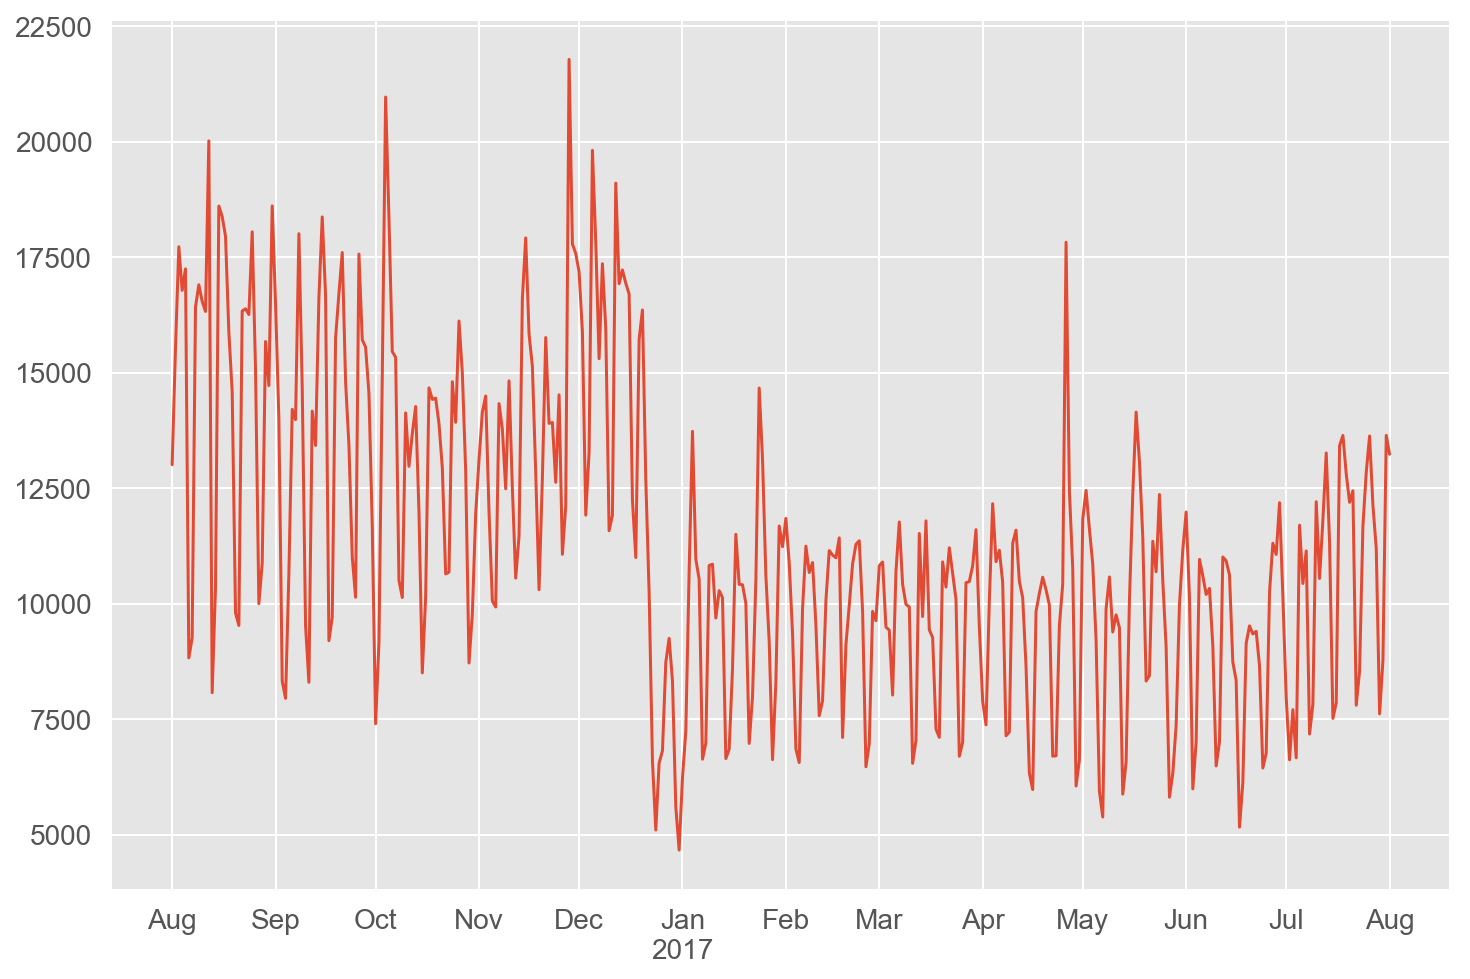

In [81]:
df.date.value_counts().sort_index().plot()

In [28]:
df.isMobile.value_counts()

False    3171247
True      982428
Name: isMobile, dtype: int64

Number of unique sessions

In [30]:
len(df['id'].unique())

903653

Top landing pages:

In [31]:
df[df.hitNumber == 1].pagePath.value_counts(ascending=False)[:10]

/home                                               612640
/google+redesign/shop+by+brand/youtube               81688
/google+redesign/apparel/men++s/men++s+t+shirts      20796
/signin.html                                         16296
/google+redesign/apparel/mens/mens+t+shirts          12738
/basket.html                                          9580
/google+redesign/drinkware                            8909
/google+redesign/bags                                 8666
/google+redesign/apparel/men++s/men++s+outerwear      6398
/google+redesign/apparel                              6363
Name: pagePath, dtype: int64

Top exit pages:

In [32]:
df[df.hitNumber == df.numHits].pagePath.value_counts(ascending=False)[:10]

/home                                              420660
/google+redesign/shop+by+brand/youtube              69857
/signin.html                                        25441
/basket.html                                        23063
/asearch.html                                       20221
/google+redesign/apparel/men++s/men++s+t+shirts     18422
/store.html                                         12334
/google+redesign/electronics                        12251
/google+redesign/apparel/mens/mens+t+shirts         12219
/google+redesign/shop+by+brand/google               11403
Name: pagePath, dtype: int64

## Pattern mining

Finding sequantial patterns (of pages).

Below we use the [`prefix span`](https://github.com/chuanconggao/PrefixSpan-py) python library.

e.g.
```python

from prefixspan import PrefixSpan

db = [
    [0, 1, 2, 3, 4],
    [1, 1, 1, 3, 4],
    [2, 1, 2, 2, 0],
    [1, 1, 1, 2, 2],
]

ps = PrefixSpan(db)

print(ps.frequent(2))
# [(2, [0]),
#  (4, [1]),
#  (3, [1, 2]),
#  (2, [1, 2, 2]),
#  (2, [1, 3]),
#  (2, [1, 3, 4]),
#  (2, [1, 4]),
#  (2, [1, 1]),
#  (2, [1, 1, 1]),
#  (3, [2]),
#  (2, [2, 2]),
#  (2, [3]),
#  (2, [3, 4]),
#  (2, [4])]

print(ps.topk(5, filter=lambda patt, matches: matches[0][0] > 0))
# [(2, [1, 1]),
#  (2, [1, 1, 1]),
#  (2, [1, 2, 2]),
#  (2, [2, 2]),
#  (1, [1, 2, 2, 0])]
```

### Dev work with `prefixspan`

In [33]:
from prefixspan import PrefixSpan

In [35]:
from sklearn.preprocessing import LabelEncoder

In [38]:
LabelEncoder?

In [39]:
page_le = LabelEncoder()
df['page_label'] = page_le.fit_transform(df.pagePath.values)

In [45]:
df.head()

,id,date,isMobile,transactions,numHits,hitNumber,pagePath,pageTitle,page_label
0,1,2016-08-01,False,NaN,3,1,/home,Home,2360
1,1,2016-08-01,False,NaN,3,2,/google+redesign/gift+cards,Gift Cards,1909
2,1,2016-08-01,False,NaN,3,3,/signin.html,The Google Merchandise Store - Log In,2423
3,2,2016-08-01,False,NaN,3,1,/home,Home,2360
4,2,2016-08-01,False,NaN,3,2,/google+redesign/apparel/men++s/men++s+t+shirts,Men's-T-Shirts,503


In [59]:
def make_page_sequences(df) -> list:
    data, d = [], []
    prev_id = df.iloc[0]['id']
    for _, row in tqdm_notebook(df.iterrows(), total=len(df)):
        if prev_id != row['id']:
            data.append(d)
            d = []
        d.append(row['page_label'])
        prev_id = row['id']

    if d:
        data.append(d)

    return data

page_sequences = make_page_sequences(df)

In [60]:
prefix_spans = PrefixSpan(page_sequences)

Solving for top sequences
Returning PrefixSpan object


In [63]:
prefix_spans.topk(10)

[(651025, [2360]),
 (224776, [2360, 2360]),
 (114101, [2317]),
 (72449, [2360, 2360, 2360]),
 (72103, [2423]),
 (71290, [3]),
 (55044, [2556]),
 (51415, [503]),
 (45148, [1683]),
 (42351, [2360, 3])]

In [68]:
def get_topk_sequences(page_sequences, k):
    prefix_spans = PrefixSpan(page_sequences)
    top_k = prefix_spans.topk(k)
    out = []
    for count, page_labels in top_k:
        out.append([count, [page_le.inverse_transform(x) for x in page_labels]])

    return out

get_topk_sequences(page_sequences, 10)

[[651025, ['/home']],
 [224776, ['/home', '/home']],
 [114101, ['/google+redesign/shop+by+brand/youtube']],
 [72449, ['/home', '/home', '/home']],
 [72103, ['/signin.html']],
 [71290, ['/basket.html']],
 [55044, ['/store.html']],
 [51415, ['/google+redesign/apparel/men++s/men++s+t+shirts']],
 [45148, ['/google+redesign/electronics']],
 [42351, ['/home', '/basket.html']]]

Let's drop all the rows where consecutive hits are from the same page (not necessary with new filtering technique - below)

In [76]:
def make_page_sequences(df) -> list:
    data, d = [], []
    prev_id = df.iloc[0]['id']
    prev_page = None
    for _, row in tqdm_notebook(df.iterrows(), total=len(df)):
        if prev_id != row['id']:
            if len(d) > 1:
                data.append(d)
            d = []
            prev_page = None
        
        if (prev_page is None) or (row['page_label'] != prev_page):
            d.append(row['page_label'])

        prev_id = row['id']
        prev_page = row['page_label']
        
    if d:
        data.append(d)

    return data

page_sequences = make_page_sequences(df)

In [79]:
for i, d in enumerate(page_sequences):
    prev = -1
    for d_ in d:
        if d_ == prev:
            print(i)
        prev = d_

In [77]:
page_sequences[:10]

[[2360, 1909, 2423],
 [2360, 503, 2025],
 [2360, 236, 2360],
 [2360, 236, 2360],
 [2360, 1394],
 [2360, 2317, 2360],
 [2360, 1613, 1683, 503],
 [2360, 2025, 1683, 2317],
 [2360, 1613, 2433, 1909, 2428],
 [2360, 1683, 1391, 1551]]

In [78]:
def get_topk_sequences(page_sequences, k, ignore_singles=True):
    prefix_spans = PrefixSpan(page_sequences)
    top_k = prefix_spans.topk(k)
    out = []
    for count, page_labels in top_k:
        if ignore_singles and (len(page_labels) == 1):
            continue
        out.append([count, [page_le.inverse_transform(x) for x in page_labels]])
        
    return out

get_topk_sequences(page_sequences, 10)

[[66741, ['/home', '/home']],
 [42351, ['/home', '/basket.html']],
 [41275, ['/home', '/signin.html']]]

Ah.. the issue here is that is that pages can be skipped. For example "home" -> "pdp" -> "home" can result in the extraction of the first pattern above :(

This behaviour is OK (for now at least), but I want to include a filter to remove rows with duplicate pages

In [90]:
def custom_filter(patt, matches):
    """
    Filter top sequence results, removing matches that
        - Have duplicate elements
        
    patt : list
        Sequential pattern e.g. [1, 2]
        
    matches : list
        Index and position of matches
        e.g. [(0, 1), (1, 0), (2, 1), (3, 0)]
    """
    patt_len = len(patt)
    if patt_len <= 1:
        return False
    elif len(set(patt)) != patt_len:
        return False
    return True

def get_topk_sequences(page_sequences, k, custom_filter):
    prefix_spans = PrefixSpan(page_sequences)
    top_k = prefix_spans.topk(k, filter=custom_filter)
    
    out = []
    for count, page_labels in top_k:
        out.append([count, [page_le.inverse_transform(x) for x in page_labels]])
        
    return out

get_topk_sequences(page_sequences, 10, custom_filter)

TypeError: PrefixSpan_topk() got an unexpected keyword argument 'min_len'

That is very slow... probably better to get the top k results and the filter myself

In [95]:
def custom_filter(patt, matches=None):
    """
    Filter top sequence results, removing matches that
        - Have length 1
        - Have duplicate elements
        
    patt : list
        Sequential pattern e.g. [1, 2]
        
    matches : list
        Index and position of matches (not used).
        e.g. [(0, 1), (1, 0), (2, 1), (3, 0)]
    """
    patt_len = len(patt)
    if patt_len <= 1:
        return False
    elif len(set(patt)) != patt_len:
        return False
    return True

def get_topk_sequences(page_sequences, k, custom_filter):
    prefix_spans = PrefixSpan(page_sequences)
    top_k = prefix_spans.topk(k)
    
    out = []
    out_labels = []
    for count, page_labels in top_k:
        if custom_filter(page_labels):
            out_labels.append([count, page_labels])
            out.append([count, [page_le.inverse_transform(label)
                                for label in page_labels]])

    return out, out_labels

topk, topk_labels = get_topk_sequences(page_sequences, 200, custom_filter)

In [96]:
topk

[[42351, ['/home', '/basket.html']],
 [41275, ['/home', '/signin.html']],
 [35474, ['/home', '/store.html']],
 [34242, ['/home', '/google+redesign/shop+by+brand/youtube']],
 [32640, ['/home', '/google+redesign/electronics']],
 [28582, ['/basket.html', '/signin.html']],
 [28457, ['/home', '/google+redesign/shop+by+brand/google']],
 [28392, ['/home', '/asearch.html']],
 [28323, ['/home', '/google+redesign/office']],
 [27515, ['/home', '/google+redesign/apparel']],
 [27068, ['/home', '/google+redesign/apparel/men++s/men++s+t+shirts']],
 [26487, ['/home', '/google+redesign/bags']],
 [26437, ['/home', '/google+redesign/drinkware']],
 [23448, ['/signin.html', '/basket.html']],
 [23242, ['/signin.html', '/store.html']],
 [22176, ['/store.html', '/basket.html']],
 [21828, ['/basket.html', '/yourinfo.html']],
 [21188, ['/basket.html', '/store.html']],
 [20005, ['/google+redesign/shop+by+brand/youtube', '/home']],
 [19999, ['/home', '/google+redesign/accessories/fun']],
 [19425, ['/home', '/goog

In [97]:
topk_labels

[[42351, [2360, 3]],
 [41275, [2360, 2423]],
 [35474, [2360, 2556]],
 [34242, [2360, 2317]],
 [32640, [2360, 1683]],
 [28582, [3, 2423]],
 [28457, [2360, 2143]],
 [28392, [2360, 0]],
 [28323, [2360, 2025]],
 [27515, [2360, 236]],
 [27068, [2360, 503]],
 [26487, [2360, 1391]],
 [26437, [2360, 1613]],
 [23448, [2423, 3]],
 [23242, [2423, 2556]],
 [22176, [2556, 3]],
 [21828, [3, 2569]],
 [21188, [3, 2556]],
 [20005, [2317, 2360]],
 [19999, [2360, 90]],
 [19425, [2360, 497]],
 [17672, [3, 2390]],
 [17603, [2423, 2569]],
 [16827, [2360, 76]],
 [16741, [2360, 3, 2423]],
 [16215, [2360, 1654]],
 [16177, [2569, 2390]],
 [16149, [3, 2569, 2390]],
 [15943, [2423, 2393]],
 [15389, [3, 2423, 2569]],
 [15312, [2423, 3, 2569]],
 [15194, [2360, 1699]],
 [14873, [2360, 2423, 2556]],
 [14734, [2393, 2556]],
 [14698, [2423, 2393, 2556]],
 [14589, [2360, 2139]],
 [14563, [2360, 1083]],
 [14450, [2423, 2556, 3]],
 [14327, [2360, 2569]],
 [14301, [2360, 3, 2569]],
 [13976, [2423, 2390]],
 [13792, [2360, 1

Save index results using a callback

In [101]:
def custom_filter(patt, matches=None):
    """
    Filter top sequence results, removing matches that
        - Have length 1
        - Have duplicate elements
        
    patt : list
        Sequential pattern e.g. [1, 2]
        
    matches : list
        Index and position of matches (not used).
        e.g. [(0, 1), (1, 0), (2, 1), (3, 0)]
    """
    patt_len = len(patt)
    if patt_len <= 1:
        return False
    elif len(set(patt)) != patt_len:
        return False
    return True

def callback(patt, matches, top_k, patt_indices, pbar):
    patt_id = '_'.join([str(x) for x in patt])
    patt_indices[patt_id] = [m[0] for m in matches]
    top_k.append([len(matches), patt])
    pbar.update(1)

def get_topk_sequences(page_sequences, k, custom_filter, callback):
    prefix_spans = PrefixSpan(page_sequences)
    patt_indices = {}
    pbar = tqdm(total=len(page_sequences))
    top_k = []
    prefix_spans.topk(k, callback=lambda patt, matches: callback(patt, matches, top_k, patt_indices, pbar))
    pbar.close()
    
    out = []
    out_labels = []
    for count, page_labels in top_k:
        if custom_filter(page_labels):
            out_labels.append([count, page_labels])
            out.append([count, [page_le.inverse_transform(label)
                                for label in page_labels]])

    return out, out_labels, patt_indices

topk, topk_labels, patt_indices = get_topk_sequences(page_sequences, 200, custom_filter, callback)

  0%|          | 200/367405 [00:57<29:17:08,  3.48it/s] 


In [102]:
topk

[[42351, ['/home', '/basket.html']],
 [41275, ['/home', '/signin.html']],
 [35474, ['/home', '/store.html']],
 [34242, ['/home', '/google+redesign/shop+by+brand/youtube']],
 [32640, ['/home', '/google+redesign/electronics']],
 [28582, ['/basket.html', '/signin.html']],
 [28457, ['/home', '/google+redesign/shop+by+brand/google']],
 [28392, ['/home', '/asearch.html']],
 [28323, ['/home', '/google+redesign/office']],
 [27515, ['/home', '/google+redesign/apparel']],
 [27068, ['/home', '/google+redesign/apparel/men++s/men++s+t+shirts']],
 [26487, ['/home', '/google+redesign/bags']],
 [26437, ['/home', '/google+redesign/drinkware']],
 [23448, ['/signin.html', '/basket.html']],
 [23242, ['/signin.html', '/store.html']],
 [22176, ['/store.html', '/basket.html']],
 [21828, ['/basket.html', '/yourinfo.html']],
 [21188, ['/basket.html', '/store.html']],
 [20005, ['/google+redesign/shop+by+brand/youtube', '/home']],
 [19999, ['/home', '/google+redesign/accessories/fun']],
 [19425, ['/home', '/goog

In [103]:
topk_labels

[[42351, [2360, 3]],
 [41275, [2360, 2423]],
 [35474, [2360, 2556]],
 [34242, [2360, 2317]],
 [32640, [2360, 1683]],
 [28582, [3, 2423]],
 [28457, [2360, 2143]],
 [28392, [2360, 0]],
 [28323, [2360, 2025]],
 [27515, [2360, 236]],
 [27068, [2360, 503]],
 [26487, [2360, 1391]],
 [26437, [2360, 1613]],
 [23448, [2423, 3]],
 [23242, [2423, 2556]],
 [22176, [2556, 3]],
 [21828, [3, 2569]],
 [21188, [3, 2556]],
 [20005, [2317, 2360]],
 [19999, [2360, 90]],
 [19425, [2360, 497]],
 [17672, [3, 2390]],
 [17603, [2423, 2569]],
 [16827, [2360, 76]],
 [16741, [2360, 3, 2423]],
 [16215, [2360, 1654]],
 [16177, [2569, 2390]],
 [16149, [3, 2569, 2390]],
 [15943, [2423, 2393]],
 [15389, [3, 2423, 2569]],
 [15312, [2423, 3, 2569]],
 [15194, [2360, 1699]],
 [14873, [2360, 2423, 2556]],
 [14734, [2393, 2556]],
 [14698, [2423, 2393, 2556]],
 [14589, [2360, 2139]],
 [14563, [2360, 1083]],
 [14450, [2423, 2556, 3]],
 [14327, [2360, 2569]],
 [14301, [2360, 3, 2569]],
 [13976, [2423, 2390]],
 [13792, [2360, 1

In [105]:
patt_labels_eg = topk_labels[0][1]
patt_eg = topk[0][1]

print('Indeces for top pattern: {} (labels={})'.format(patt_eg, patt_labels_eg))
patt_indices['_'.join([str(x) for x in patt_labels_eg])]

Indeces for top pattern: ['/home', '/basket.html'] (labels=[2360, 3])


[22,
 23,
 28,
 68,
 182,
 219,
 274,
 294,
 303,
 315,
 346,
 374,
 387,
 389,
 402,
 420,
 425,
 434,
 437,
 443,
 450,
 455,
 459,
 460,
 466,
 479,
 482,
 505,
 507,
 513,
 518,
 522,
 527,
 531,
 532,
 534,
 536,
 541,
 546,
 549,
 551,
 558,
 561,
 565,
 566,
 568,
 572,
 577,
 579,
 582,
 586,
 596,
 600,
 601,
 603,
 608,
 610,
 612,
 615,
 616,
 618,
 622,
 623,
 627,
 628,
 629,
 632,
 633,
 640,
 642,
 644,
 650,
 656,
 660,
 663,
 665,
 670,
 674,
 677,
 679,
 680,
 681,
 684,
 686,
 691,
 692,
 694,
 696,
 702,
 704,
 712,
 713,
 715,
 716,
 722,
 724,
 725,
 726,
 727,
 728,
 729,
 730,
 731,
 735,
 736,
 737,
 739,
 740,
 741,
 744,
 745,
 747,
 748,
 755,
 757,
 758,
 759,
 760,
 762,
 763,
 765,
 767,
 769,
 770,
 771,
 773,
 774,
 780,
 782,
 783,
 785,
 786,
 787,
 788,
 789,
 791,
 792,
 795,
 796,
 797,
 798,
 799,
 844,
 892,
 1014,
 1018,
 1122,
 1149,
 1180,
 1212,
 1282,
 1283,
 1291,
 1353,
 1357,
 1358,
 1363,
 1365,
 1412,
 1432,
 1448,
 1461,
 1463,
 1482,


We can use these to map back onto training data.

In [107]:
len(df)

4153675

In [108]:
len(page_sequences)

367405

### Session aggregate dataframe

In [120]:
def make_session_agg_df(df) -> pd.DataFrame:
    df_ = df.copy()
    df_.transactions = df_.transactions.fillna(0)
    
    data = []
    cols = ['id', 'date', 'is_mobile', 'transactions', 'num_hits',
            'page_paths', 'page_titles', 'page_labels']

    for id_ in tqdm_notebook(df_['id'].drop_duplicates().tolist()):
        m = df_['id'] == id_
        s = df_[m]
        data.append([
            id_,
            s.date.iloc[0],
            s.isMobile.iloc[0],
            s.transactions.sum(),
            s.numHits.iloc[0],
            s.pagePath.tolist(),
            s.pageTitle.tolist(),
            s.page_label.tolist(),
        ])
        
    return pd.DataFrame(data, columns=cols)
        
df_sess = make_session_agg_df(df)

In [ ]:
df_sess.page_titles.values.sum()[:10]

In [ ]:
from sklearn.preprocessing import LabelEncoder

page_path_le = LabelEncoder()
df['page_path_labels'] = df.page_paths.apply(lambda x: [page_path_le.transform(x_) for x_ in x])

page_title_le = LabelEncoder()
page_title_le.fit(sum(df.page_titles.tolist()))
df['page_title_labels'] = df.page_titles.apply(lambda x: [page_title_le.transform(x_) for x_ in x])

In [121]:
df_sess.head()

,id,date,is_mobile,transactions,num_hits,page_paths,page_titles,page_labels
0,1,2016-08-01,False,0.0,3,"[/home, /google+redesign/gift+cards, /signin.h...","[Home, Gift Cards, The Google Merchandise Stor...","[2360, 1909, 2423]"
1,2,2016-08-01,False,0.0,3,"[/home, /google+redesign/apparel/men++s/men++s...","[Home, Men's-T-Shirts, Office]","[2360, 503, 2025]"
2,3,2016-08-01,False,0.0,4,"[/home, /home, /google+redesign/apparel, /home]","[Home, Home, Apparel, Home]","[2360, 2360, 236, 2360]"
3,4,2016-08-01,False,0.0,4,"[/home, /google+redesign/apparel, /home, /home]","[Home, Apparel, Home, Home]","[2360, 236, 2360, 2360]"
4,5,2016-08-01,False,0.0,4,"[/home, /home, /google+redesign/bags/backpacks...","[Home, Home, Backpacks, Backpacks]","[2360, 2360, 1394, 1394]"


In [122]:
df_sess.tail()

,id,date,is_mobile,transactions,num_hits,page_paths,page_titles,page_labels
903648,903649,2017-08-01,True,0.0,11,"[/google+redesign/shop+by+brand/youtube, /goog...",[YouTube | Shop by Brand | Google Merchandise ...,"[2317, 2323, 2317, 2360, 0, 2317, 2323, 2317, ..."
903649,903650,2017-08-01,False,0.0,12,[/google+redesign/apparel/men+s+t+shirts/googl...,"[Google Toddler Short Sleeve Tee Red, Google T...","[838, 441, 1654, 90, 2090, 2090, 2091, 2091, 2..."
903650,903651,2017-08-01,False,0.0,14,[/google+redesign/apparel/womens+performance+w...,[Women's Performance Wear | Apparel | Google M...,"[1299, 1299, 1300, 1299, 1300, 1299, 1300, 107..."
903651,903652,2017-08-01,False,0.0,14,"[/google+redesign/shop+by+brand/youtube, /goog...",[YouTube | Shop by Brand | Google Merchandise ...,"[2317, 2317, 2323, 2323, 2317, 2323, 2317, 456..."
903652,903653,2017-08-01,True,0.0,18,"[/google+redesign/shop+by+brand/youtube, /stor...",[YouTube | Shop by Brand | Google Merchandise ...,"[2317, 2556, 2317, 2556, 2360, 2360, 2360, 3, ..."


In [123]:
df_sess.dtypes

id                       int64
date            datetime64[ns]
is_mobile                 bool
transactions           float64
num_hits                 int64
page_paths              object
page_titles             object
page_labels             object
dtype: object

In [18]:
df_sess.to_csv('../../data/interim/page_paths_sess_agg_raw.csv', index=False)
df_sess.to_pickle('../../data/interim/page_paths_sess_agg_raw.pkl')

In [19]:
def load_file(f_path, load_pkl):
    if not os.path.exists(f_path):
        print('No data found. Run data load script above.')
        return
    print('Loading {}'.format(f_path))
    if load_pkl:
        df = pd.read_pickle(f_path)
    else:
        df = pd.read_csv(f_path)
        df.date = pd.to_datetime(df.date)
    return df

# Looking forward to walrus operator for stuff like this...
tmp = load_file('../../data/interim/page_paths_sess_agg_raw.pkl')
if tmp is not None:
    print('Loading from file')
    df_sess = tmp.copy()
    del tmp

Loading ../../data/interim/page_paths_raw.csv
Loading from file


In [126]:
df_sess.head()

,id,date,is_mobile,transactions,num_hits,page_paths,page_titles,page_labels
0,1,2016-08-01,False,0.0,3,"[/home, /google+redesign/gift+cards, /signin.h...","[Home, Gift Cards, The Google Merchandise Stor...","[2360, 1909, 2423]"
1,2,2016-08-01,False,0.0,3,"[/home, /google+redesign/apparel/men++s/men++s...","[Home, Men's-T-Shirts, Office]","[2360, 503, 2025]"
2,3,2016-08-01,False,0.0,4,"[/home, /home, /google+redesign/apparel, /home]","[Home, Home, Apparel, Home]","[2360, 2360, 236, 2360]"
3,4,2016-08-01,False,0.0,4,"[/home, /google+redesign/apparel, /home, /home]","[Home, Apparel, Home, Home]","[2360, 236, 2360, 2360]"
4,5,2016-08-01,False,0.0,4,"[/home, /home, /google+redesign/bags/backpacks...","[Home, Home, Backpacks, Backpacks]","[2360, 2360, 1394, 1394]"


### Modling converting / non-converting sessions with page path features

### Page sequence trends over time

### Top page transitions

Given a specific page, what's the probability of going to each other page? Where does site exits rank in here.

### TODO

- Add DATA_PATH global variable to Gdrive. Move `interim` files


- Predict purchase intent with decision tree. Look at top features. Feature engineering ideas:
    - Split out into converting and non-converting segments
    - Split out into mobile vs desktop


- See how page sequence trends change over time
- Given a specific page, what's the most common next page(s)?

In [82]:
from IPython.display import HTML
HTML('<style>div.text_cell_render{font-size:130%;padding-top:50px;padding-bottom:50px}</style>')